In [1]:

import torch
from typing import Sequence, Literal
import matplotlib.pyplot as plt
import pandas as pd

def add_gaussian_noise_xy(  # name kept for drop-in; now soft-step by default
    xy: torch.Tensor,                 # (N, 2)
    u: torch.Tensor,                  # (N, 1) or (N,)
    *,
    centers: Sequence[Sequence[float]],
    radii: float | Sequence[float] | Sequence[Sequence[float]],
    sigmas: float | Sequence[float],
    base_sigma: float = 0.0,          # background noise std
    index_eps: float = 1e-6,          # threshold above background to count as "modified"
    generator: torch.Generator | None = None,
    clamp: tuple[float, float] | None = None,
    return_sigma: bool = False,
    combine: Literal["sum", "max", "quadrature"] = "sum",
    edge_tau: float = 0.05,           # NEW: softness of the boundary (in normalized radial units)
):
    """
    Adds heteroscedastic noise with *soft-step* 'islands':
      For each center c_k with radius r_k (or ellipse (rx, ry)),
      points get extra noise S_k weighted by a smooth indicator:

          w_k(x) = sigmoid( (1 - d_k(x)) / edge_tau ),
          d_k(x) = sqrt( ((x - c_k)/r_k)^T ((x - c_k)/r_k) )  (normalized distance)

      So w_k ≈ 1 deep inside (d<<1), w_k ≈ 0.5 at the boundary (d=1),
      and w_k → 0 smoothly outside.

    Aggregation across overlapping regions is controlled by `combine`:
      - "sum"        : sigma = base_sigma + sum_k S_k * w_k
      - "max"        : sigma = base_sigma + max_k (S_k * w_k)
      - "quadrature" : sigma = sqrt(base_sigma^2 + sum_k (S_k^2 * w_k^2))

    Returns:
        (u_noisy, idx)                 OR
        (u_noisy, sigma, idx)          if return_sigma=True
      - u_noisy: (N, 1)
      - sigma:   (N, 1) (only if return_sigma=True)
      - idx:     1D LongTensor where (sigma - base_sigma) > index_eps

    Notes:
      - `edge_tau` is in normalized radial units (relative to each island’s radius).
        As a rough rule, the 10–90% transition width in d is ≈ 4.394 * edge_tau.
        Set edge_tau→small (e.g., 0.01) to approach a hard step.
    """
    # --- shape checks / normalize ---
    if xy.ndim != 2 or xy.shape[1] != 2:
        raise ValueError("xy must have shape (N, 2)")
    u = u.reshape(-1, 1)
    if xy.shape[0] != u.shape[0]:
        raise ValueError("xy and u must have the same number of points (N)")

    device, dtype = u.device, u.dtype
    XY = xy.to(device=device, dtype=dtype)

    # --- centers ---
    C = torch.as_tensor(centers, dtype=dtype, device=device).reshape(-1, 2)  # (K,2)
    K = C.shape[0]

    # Fast path: no centers -> background only
    if K == 0:
        sigma = torch.full_like(u, float(base_sigma))
        noise = torch.normal(mean=torch.zeros_like(u), std=sigma, generator=generator)
        u_noisy = u + noise
        if clamp is not None:
            lo, hi = clamp
            u_noisy = u_noisy.clamp(min=lo, max=hi)
        idx = torch.zeros(0, dtype=torch.long, device=device)
        return (u_noisy, sigma, idx) if return_sigma else (u_noisy, idx)

    # --- per-center amplitudes (S) ---
    S = (torch.full((K,), float(sigmas), dtype=dtype, device=device)
         if isinstance(sigmas, (int, float))
         else torch.as_tensor(sigmas, dtype=dtype, device=device).reshape(-1))
    if S.numel() != K:
        raise ValueError("sigmas must be scalar or length == len(centers)")

    # --- radii: scalar, (K,), or (K,2) for anisotropic (rx, ry) ---
    R_raw = torch.as_tensor(radii, dtype=dtype, device=device)
    if R_raw.ndim == 0:
        R_iso = R_raw.expand(K)    # isotropic radius shared by all
        R_aniso = None
    elif R_raw.ndim == 1:
        if R_raw.numel() != K:
            raise ValueError("radii 1D must have length == len(centers)")
        R_iso = R_raw
        R_aniso = None
    elif R_raw.ndim == 2 and R_raw.shape == (K, 2):
        R_iso = None
        R_aniso = R_raw
    else:
        raise ValueError("radii must be scalar, length-K, or shape (K,2) for anisotropic")

    # --- compute normalized squared distance Q and soft weights w ---
    diff = XY[:, None, :] - C[None, :, :]          # (N,K,2)
    tiny = torch.finfo(dtype).tiny
    if R_aniso is None:
        R2 = (R_iso.clamp_min(tiny)) ** 2          # (K,)
        Q  = (diff.pow(2).sum(dim=2)) / R2[None, :]   # (N,K)
    else:
        R2 = (R_aniso.clamp_min(tiny)) ** 2        # (K,2)
        Q  = (diff.pow(2) / R2[None, :, :]).sum(dim=2)  # (N,K)

    # normalized radial distance d = sqrt(Q); smooth indicator via logistic around d=1
    d = Q.clamp_min(0).sqrt()
    tau = max(float(edge_tau), 1e-12)
    w = torch.sigmoid((1.0 - d) / tau).to(dtype)   # (N,K) in (0,1)

    # --- aggregate sigma by chosen rule ---
    if combine == "sum":
        add = w * S[None, :]                        # (N,K)
        sigma = add.sum(dim=1, keepdim=True) + float(base_sigma)
    elif combine == "max":
        add = w * S[None, :]
        sigma = add.max(dim=1, keepdim=True).values + float(base_sigma)
    elif combine == "quadrature":
        add = (w * S[None, :]) ** 2
        sigma = (add.sum(dim=1, keepdim=True) + float(base_sigma) ** 2).sqrt()
    else:
        raise ValueError("combine must be one of: 'sum', 'max', 'quadrature'")

    sigma = sigma.clamp_min(0)

    # indices where island contribution > background
    idx = torch.nonzero((sigma.view(-1) - float(base_sigma)) > float(index_eps),
                        as_tuple=False).squeeze(1)

    # --- sample noise & add ---
    noise = torch.normal(mean=torch.zeros_like(u), std=sigma, generator=generator)
    u_noisy = u + noise
    if clamp is not None:
        lo, hi = clamp
        u_noisy = u_noisy.clamp(min=lo, max=hi)

    return (u_noisy, sigma, idx) if return_sigma else (u_noisy, idx)


In [2]:
# ────────────────────────────────────────────────────────────────────────────────
# 0. Imports & reproducibility
# ────────────────────────────────────────────────────────────────────────────────
import math, random, numpy as np, torch
from torch import nn
# Basic
import torch
import math
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
import numpy as np
from numpy import random
# torch.set_num_threads(4)

# PDEi
from utils_pde.utils_pde_2dpoisson import Poisson2D

# Viz
from utils_tools.utils_result_viz import plot_predictions_2D
from utils_tools.utils_tuning import save_plot

# Base Mdoels
from utils_uqmd.utils_uq_dropout import DropoutPINN
from utils_uqmd.utils_uq_mlp import MLPPINN
from utils_uqmd.utils_uq_vi import VIBPINN
from utils_uqmd.utils_uq_distance import DistanceUQPINN

# CP
from utils_uqmd.utils_uq_cp import CP

torch.set_num_threads(4)
seed = 11111
random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

# ────────────────────────────────────────────────────────────────────────────────
# 1. Ground-truth PDE setup 
# ────────────────────────────────────────────────────────────────────────────────
from utils_pde.utils_pde_allencahn2d import AllenCahn2D

# 1) keep the torch-based definition
def true_solution(xy):
    return torch.sin(math.pi*xy[...,0:1]) * torch.sin(math.pi*xy[...,1:2])

domain=((-1.0, 1.0), (-1.0, 1.0))
pde = AllenCahn2D(lam=0.05, domain=domain, true_solution=true_solution)

# ────────────────────────────────────────────────────────────────────────────────
# 2. Data Generation (Noisy data for training, test, calibration)
# ────────────────────────────────────────────────────────────────────────────────
colloc_pt_num = 250  # Number of collocation points

data_noise = 0.05
N_train = 300
N_test = 1000 # 2000
N_calib = 100
N_valid = 200

N_total= N_train+N_test+N_calib

X_train, Y_train = pde.data_generation(N_train, data_noise)
X_test, Y_test = pde.data_generation(N_test, data_noise)
X_calibration, Y_calibration = pde.data_generation(N_calib, data_noise)
X_validation, Y_validation= pde.data_generation(N_valid, data_noise)

X_vis, Y_vis = pde.data_generation(N_total, data_noise)
# Generating alphas to test
from utils_tools.utils_result_metrics import generating_alphas
alphas = generating_alphas(n=20, step=0.05)

alpha = 0.05

# ────────────────────────────────────────────────────────────────────────────────
# 3. Visualization: Plot ground-truth & noisy data
# ────────────────────────────────────────────────────────────────────────────────

def make_dense_grid(domain, N=200):
    x = np.linspace(domain[0][0], domain[0][1], N)
    y = np.linspace(domain[1][0], domain[1][1], N)
    X, Y = np.meshgrid(x, y)
    XY_grid = np.stack([X.ravel(), Y.ravel()], axis=-1)
    return XY_grid, X, Y

import matplotlib.pyplot as plt

def plot_truth_and_samples_2D(
    X_train, Y_train, grid, U_true_grid, domain,
    title="Allen-Cahn 2D: ground-truth vs noisy data"
):
    fig, ax = plt.subplots(figsize=(7, 6))
    # Show the true solution as a colormap
    x = np.linspace(domain[0][0], domain[0][1], U_true_grid.shape[0])
    y = np.linspace(domain[1][0], domain[1][1], U_true_grid.shape[1])
    im = ax.imshow(
        U_true_grid,
        extent=(domain[0][0], domain[0][1], domain[1][0], domain[1][1]),
        origin='lower',
        aspect='auto',
        alpha=0.8,
        cmap='coolwarm'
    )
    # Overlay noisy training points
    ax.scatter(X_train[:,0], X_train[:,1], c=Y_train, edgecolor='k', cmap='viridis', s=18, label="Noisy samples")
    plt.colorbar(im, ax=ax, label="u(x, y)")
    ax.set_xlabel("x"); ax.set_ylabel("y")
    ax.set_title(title)
    ax.legend()
    plt.tight_layout()



# 4) plot again
grid_test, X_mesh, Y_mesh = make_dense_grid(domain, 200)
grid_test_torch = torch.tensor(grid_test, dtype=torch.float32)
U_true_grid = true_solution(grid_test_torch).numpy().reshape(X_mesh.shape)


# --------------------------------------------
# Defining Testing
# --------------------------------------------
n_grid = 200
g  = torch.Generator().manual_seed(seed)

# Define printing grid
grid_test, u = pde.solution_field_on_grid(n_grid, source="true", flatten=True)
u_noisy, sigma, id_grid = add_gaussian_noise_xy(
    grid_test, u,
    centers=[(0.0,0.0)],
    radii=[0.2,],
    sigmas=[0.45,],
    base_sigma=0.05,
    combine="sum",
    generator=g,
    return_sigma=True,
    edge_tau=0.2
)

Y_train_clean = Y_train.clone()
Y_test_clean  = Y_test.clone()
Y_cal_clean   = Y_calibration.clone()

Y_train, sigma_train, id_train = add_gaussian_noise_xy(
    X_train, Y_train_clean,
    centers=[(0.0,0.0)],
    radii=[0.2,],
    sigmas=[0.45,],
    base_sigma=0.0,
    combine="sum",
    generator=g,
    return_sigma=True,
    edge_tau=0.2
)
Y_test, sigma_test, id_test = add_gaussian_noise_xy(
    X_test, Y_test_clean,
    centers=[(0.0,0.0)],
    radii=[0.2,],
    sigmas=[0.45,],
    base_sigma=0.0,
    combine="sum",
    generator=g,
    return_sigma=True,
    edge_tau=0.2
)
Y_calibration, sigma_calibration, id_calibration = add_gaussian_noise_xy(
    X_calibration, Y_cal_clean,
    centers=[(0.0,0.0)],
    radii=[0.2,],
    sigmas=[0.45,],
    base_sigma=0.0,
    combine="sum",
    generator=g,
    return_sigma=True,
    edge_tau=0.2
)


save_plot(
    plot_truth_and_samples_2D,
    save_dir="2D_AllenCahn", prefix="2D_AllenCahn_data",
)(
    X_test, Y_test, grid_test, U_true_grid, domain,
    title="Allen-Cahn 2D: ground-truth vs noisy data"
)

/Users/yifanyu/miniconda3/envs/cp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu
Using device: cpu


<Figure size 640x480 with 0 Axes>

# Change make the noise sharper and larger, currently too few sample are considered as out of CP interval.

# Try step-wise disc noise added.

# Step wise noise

In [3]:

import torch
from typing import Sequence, Literal
import matplotlib.pyplot as plt
import pandas as pd

def plot_metrics_table(
    X_test: torch.Tensor,
    cp_uncal_predset,
    cp_cal_predset,
    true_solution,
    df1: pd.DataFrame,
    df2: pd.DataFrame,
    df1_name: str="Uncalibrated",
    df2_name: str="Calibrated",
    title: str = "",
    main_title: str | None = None,
    X_vis=None, Y_vis=None,
    alpha_level: float = 0.05,
    figsize: tuple = (9, 2.5),
    max_digits_display = lambda x: f"{x:.4g}"
):
    """
    Display a side-by-side metrics comparison (table) for the uncalibrated and
    calibrated models at a single alpha level.
    """
    # Compute the coverage deviation using mae
    def prepare_coverage_data(df):
        expected = 1 - df["alpha"]
        empirical = df["coverage"]
        exp_full = pd.concat([pd.Series([0.0]), expected, pd.Series([1.0])], ignore_index=True)
        emp_full = pd.concat([pd.Series([0.0]), empirical, pd.Series([1.0])], ignore_index=True)
        sort_idx = exp_full.argsort()
        exp_sorted, emp_sorted = exp_full[sort_idx], emp_full[sort_idx]
        return exp_sorted.to_numpy(), emp_sorted.to_numpy()

    def coverage_deviation(exp, emp, how="mae"):
        diff = np.abs(emp - exp)
        if   how == "mae":  return diff.mean()
        elif how == "rmse": return np.sqrt((diff**2).mean())
        elif how == "max":  return diff.max()
        else:
            raise ValueError("metric must be 'mae', 'rmse', or 'max'")

    exp1, emp1 = prepare_coverage_data(df1)
    exp2, emp2 = prepare_coverage_data(df2)
    dev1 = coverage_deviation(exp1, emp1)  # Using the default metrics
    dev2 = coverage_deviation(exp2, emp2)  # Using the default metrics
    print(f"Uncal dev:{dev1}")
    print(f"Cal dev:{dev2}")
    alpha_level_upper = alpha_level + 1e-3
    alpha_level_lower = alpha_level - 1e-3
    
    # ────────────────────── 1. Slice the two rows ──────────────────────
    row_uncal = df1.loc[(df1["alpha"] <= alpha_level_upper) & 
                           (df1["alpha"] >= alpha_level_lower)].copy()
    row_uncal["model"] = df1_name
    row_uncal["expected coverage"] = (1 - row_uncal["alpha"])
    row_uncal["mean coverage deviation"] = "{:.4f}".format(dev1)
    row_uncal["coverage"] = (row_uncal["coverage"]).map("{:.2f}".format)

    row_cal = df2.loc[(df2["alpha"] <= alpha_level_upper) & 
                        (df2["alpha"] >= alpha_level_lower)].copy()
    row_cal["model"] = df2_name
    row_cal["expected coverage"] = (1- row_cal["alpha"])
    row_cal["mean coverage deviation"] = "{:.4f}".format(dev2)
    row_cal["coverage"] = (row_cal["coverage"]).map("{:.2f}".format)

    if row_uncal.empty or row_cal.empty:
        raise ValueError(f"alpha={alpha_level} not found in both data frames.")

    # ───────────────────── 2. Stack & tidy up ──────────────────────────
    rows = pd.concat([row_uncal, row_cal], axis=0).reset_index(drop=True)
    rows = rows.rename(columns={"coverage": "actual coverage"})
    # Get all columns except 'model' for the selection
    other_cols = [c for c in rows.columns if c != "model"]
    rows = rows.loc[:, ["model"] + other_cols]

    
    # nice ordering: model | expected alpha | true alpha | <metrics…>
    metric_cols = [c for c in rows.columns if c not in ("model", "expected coverage", "actual coverage", "mean coverage deviation", "sharpness")]
    rows = rows[["model", "expected coverage", "actual coverage", "mean coverage deviation", "sharpness"]]
    

    # ──────────────── 2.5. Format numeric values ───────────────────────
    # Format all numeric columns to 4 decimal places (excluding 'model' column)
    for col in rows.columns:
        if pd.api.types.is_numeric_dtype(rows[col]):
            rows[col] = rows[col].apply(max_digits_display)  # .4g gives up to 4 significant 

    # ───────────────────── 3. Plot as table ────────────────────────────
    fig, ax = plt.subplots(figsize=figsize)
    ax.axis("off")

    table = ax.table(
        cellText=rows.values,
        colLabels=rows.columns,
        loc="center",
        cellLoc="center",
    )

    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 1.25)

    if main_title is not None:
        plt.title(main_title, pad=20, fontsize=12)

    plt.tight_layout()


x-range: -1.0 1.0
y-range: -1.0 1.0


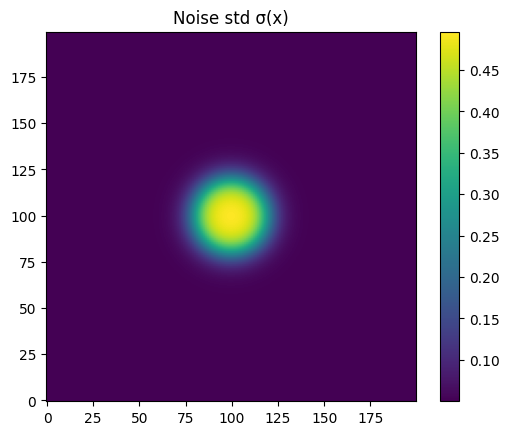

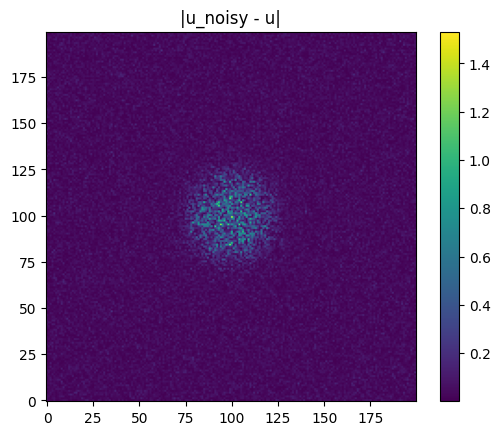

In [4]:
# 1) Make sure both centers lie in your domain
print("x-range:", grid_test[:,0].min().item(), grid_test[:,0].max().item())
print("y-range:", grid_test[:,1].min().item(), grid_test[:,1].max().item())
# If your domain isn’t ~[0,1]×[0,1], adjust centers/radii accordingly.

# 2) Visualize the heteroscedasticity itself
n = int((grid_test.shape[0])**0.5)
Sigma_grid = sigma.view(n, n)
plt.imshow(Sigma_grid.cpu(), origin="lower")     # or cmap="magma"
plt.title("Noise std σ(x)")
plt.colorbar()

# 3) Alternatively, look at absolute error from a single draw
err = (u_noisy - u).abs().view(n, n)
plt.figure(); plt.imshow(err.cpu(), origin="lower"); plt.title("|u_noisy - u|"); plt.colorbar()


# Gussian Noise

In [5]:
# import torch
# from typing import Sequence

# def add_gaussian_noise_xy(
#     xy: torch.Tensor,                 # (N, 2)
#     u: torch.Tensor,                  # (N, 1) or (N,)
#     *,
#     centers: Sequence[Sequence[float]],
#     radii: float | Sequence[float] | Sequence[Sequence[float]],
#     sigmas: float | Sequence[float],
#     base_sigma: float = 0.0,          # background noise std
#     index_eps: float = 1e-6,          # threshold above background to count as "modified"
#     generator: torch.Generator | None = None,
#     clamp: tuple[float, float] | None = None,
#     return_sigma: bool = False,
#     truncate_outside: bool = False,   # NEW: zero island contribution outside the "radius"
# ):
#     """
#     Adds heteroscedastic Gaussian noise with radial/elliptical Gaussian "islands":
#         σ(x) = base_sigma + sum_k S[k] * exp(-0.5 * Q_k(x))
#     where
#         Q_k(x) = (||x - c_k|| / R[k])^2               if R is isotropic (scalar per center)
#                = sum_j ((x_j - c_{k,j}) / R_{k,j})^2  if R is anisotropic (rx, ry per center)

#     If truncate_outside=True, contributions with Q_k(x) > 1 are set to 0 (hard cutoff).

#     Returns:
#         (u_noisy, idx)                 OR
#         (u_noisy, sigma, idx)          if return_sigma=True
#       - u_noisy: (N, 1)
#       - sigma:   (N, 1) (only if return_sigma=True)
#       - idx:     1D LongTensor where (σ - base_sigma) > index_eps
#     """
#     # --- shape checks / normalize ---
#     if xy.ndim != 2 or xy.shape[1] != 2:
#         raise ValueError("xy must have shape (N, 2)")
#     u = u.reshape(-1, 1)
#     if xy.shape[0] != u.shape[0]:
#         raise ValueError("xy and u must have the same number of points (N)")

#     device, dtype = u.device, u.dtype
#     XY = xy.to(device=device, dtype=dtype)

#     # --- centers ---
#     C = torch.as_tensor(centers, dtype=dtype, device=device).reshape(-1, 2)  # (K,2)
#     K = C.shape[0]

#     # --- fast path: no centers -> only background noise ---
#     if K == 0:
#         sigma = torch.full_like(u, float(base_sigma))
#         noise = torch.normal(mean=torch.zeros_like(u), std=sigma, generator=generator)
#         u_noisy = u + noise
#         if clamp is not None:
#             lo, hi = clamp
#             u_noisy = u_noisy.clamp(min=lo, max=hi)
#         idx = torch.zeros(0, dtype=torch.long, device=device)
#         return (u_noisy, sigma, idx) if return_sigma else (u_noisy, idx)

#     # --- sigmas per center ---
#     S = (torch.full((K,), float(sigmas), dtype=dtype, device=device)
#          if isinstance(sigmas, (int, float))
#          else torch.as_tensor(sigmas, dtype=dtype, device=device).reshape(-1))
#     if S.numel() != K:
#         raise ValueError("sigmas must be scalar or length == len(centers)")

#     # --- radii parsing: supports scalar, (K,), or (K,2) for anisotropic ---
#     R_raw = torch.as_tensor(radii, dtype=dtype, device=device)
#     if R_raw.ndim == 0:
#         R_iso = R_raw.expand(K)    # isotropic, one scalar for all centers
#         R_aniso = None
#     elif R_raw.ndim == 1:
#         if R_raw.numel() != K:
#             raise ValueError("radii 1D must have length == len(centers)")
#         R_iso = R_raw
#         R_aniso = None
#     elif R_raw.ndim == 2 and R_raw.shape == (K, 2):
#         R_iso = None
#         R_aniso = R_raw
#     else:
#         raise ValueError("radii must be scalar, length-K, or shape (K,2) for anisotropic")

#     # --- compute Q_k(x) for all points/centers ---
#     # diff: (N,K,2)
#     diff = XY[:, None, :] - C[None, :, :]

#     tiny = torch.finfo(dtype).tiny
#     if R_aniso is None:
#         # isotropic: Q = ||diff||^2 / R^2
#         R2 = (R_iso.clamp_min(tiny)) ** 2                    # (K,)
#         Q = (diff.pow(2).sum(dim=2)) / R2[None, :]          # (N,K)
#     else:
#         # anisotropic: Q = sum_j (diff_j / R_j)^2
#         R2 = (R_aniso.clamp_min(tiny)) ** 2                  # (K,2)
#         Q = (diff.pow(2) / R2[None, :, :]).sum(dim=2)       # (N,K)

#     # optional hard cutoff
#     if truncate_outside:
#         mask = (Q <= 1.0)
#     else:
#         mask = None

#     # --- contributions per center ---
#     contrib = torch.exp(-0.5 * Q) * S[None, :]              # (N,K)
#     if mask is not None:
#         contrib = contrib * mask

#     sigma = contrib.sum(dim=1, keepdim=True)                # (N,1)
#     if base_sigma:
#         sigma = sigma + float(base_sigma)
#     sigma = sigma.clamp_min(0)

#     # indices where island contribution > background
#     idx = torch.nonzero((sigma.view(-1) - float(base_sigma)) > float(index_eps),
#                         as_tuple=False).squeeze(1)

#     # --- sample noise & add ---
#     noise = torch.normal(mean=torch.zeros_like(u), std=sigma, generator=generator)
#     u_noisy = u + noise
#     if clamp is not None:
#         lo, hi = clamp
#         u_noisy = u_noisy.clamp(min=lo, max=hi)

#     return (u_noisy, sigma, idx) if return_sigma else (u_noisy, idx)


In [6]:
# # ────────────────────────────────────────────────────────────────────────────────
# # 0. Imports & reproducibility
# # ────────────────────────────────────────────────────────────────────────────────
# import math, random, numpy as np, torch
# from torch import nn
# # Basic
# import torch
# import math
# import torch.nn as nn
# from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
# import numpy as np
# from numpy import random
# # torch.set_num_threads(4)

# # PDEi
# from utils_pde.utils_pde_2dpoisson import Poisson2D

# # Viz
# from utils_tools.utils_result_viz import plot_predictions_2D
# from utils_tools.utils_tuning import save_plot

# # Base Mdoels
# from utils_uqmd.utils_uq_dropout import DropoutPINN
# from utils_uqmd.utils_uq_mlp import MLPPINN
# from utils_uqmd.utils_uq_vi import VIBPINN
# from utils_uqmd.utils_uq_distance import DistanceUQPINN

# # CP
# from utils_uqmd.utils_uq_cp import CP

# torch.set_num_threads(4)
# seed = 5902
# random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
# if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

# # ────────────────────────────────────────────────────────────────────────────────
# # 1. Ground-truth PDE setup 
# # ────────────────────────────────────────────────────────────────────────────────
# from utils_pde.utils_pde_allencahn2d import AllenCahn2D

# # 1) keep the torch-based definition
# def true_solution(xy):
#     return torch.sin(math.pi*xy[...,0:1]) * torch.sin(math.pi*xy[...,1:2])

# domain=((-1.0, 1.0), (-1.0, 1.0))
# pde = AllenCahn2D(lam=0.05, domain=domain, true_solution=true_solution)

# # ────────────────────────────────────────────────────────────────────────────────
# # 2. Data Generation (Noisy data for training, test, calibration)
# # ────────────────────────────────────────────────────────────────────────────────
# colloc_pt_num = 250  # Number of collocation points

# data_noise = 0.05
# N_train = 500
# N_test = 20000
# N_calib = 200
# N_valid = 200

# N_total= N_train+N_test+N_calib

# X_train, Y_train = pde.data_generation(N_train, data_noise)
# X_test, Y_test = pde.data_generation(N_test, data_noise)
# X_calibration, Y_calibration = pde.data_generation(N_calib, data_noise)
# X_validation, Y_validation= pde.data_generation(N_valid, data_noise)

# X_vis, Y_vis = pde.data_generation(N_total, data_noise)
# # Generating alphas to test
# from utils_tools.utils_result_metrics import generating_alphas
# alphas = generating_alphas()

# alpha = 0.05

# # ────────────────────────────────────────────────────────────────────────────────
# # 3. Visualization: Plot ground-truth & noisy data
# # ────────────────────────────────────────────────────────────────────────────────

# def make_dense_grid(domain, N=200):
#     x = np.linspace(domain[0][0], domain[0][1], N)
#     y = np.linspace(domain[1][0], domain[1][1], N)
#     X, Y = np.meshgrid(x, y)
#     XY_grid = np.stack([X.ravel(), Y.ravel()], axis=-1)
#     return XY_grid, X, Y

# import matplotlib.pyplot as plt

# def plot_truth_and_samples_2D(
#     X_train, Y_train, grid, U_true_grid, domain,
#     title="Allen-Cahn 2D: ground-truth vs noisy data"
# ):
#     fig, ax = plt.subplots(figsize=(7, 6))
#     # Show the true solution as a colormap
#     x = np.linspace(domain[0][0], domain[0][1], U_true_grid.shape[0])
#     y = np.linspace(domain[1][0], domain[1][1], U_true_grid.shape[1])
#     im = ax.imshow(
#         U_true_grid,
#         extent=(domain[0][0], domain[0][1], domain[1][0], domain[1][1]),
#         origin='lower',
#         aspect='auto',
#         alpha=0.8,
#         cmap='coolwarm'
#     )
#     # Overlay noisy training points
#     ax.scatter(X_train[:,0], X_train[:,1], c=Y_train, edgecolor='k', cmap='viridis', s=18, label="Noisy samples")
#     plt.colorbar(im, ax=ax, label="u(x, y)")
#     ax.set_xlabel("x"); ax.set_ylabel("y")
#     ax.set_title(title)
#     ax.legend()
#     plt.tight_layout()



# # 4) plot again
# grid_test, X_mesh, Y_mesh = make_dense_grid(domain, 200)
# grid_test_torch = torch.tensor(grid_test, dtype=torch.float32)
# U_true_grid = true_solution(grid_test_torch).numpy().reshape(X_mesh.shape)


# # --------------------------------------------
# # Defining Testing
# # --------------------------------------------
# n_grid = 200
# g  = torch.Generator().manual_seed(seed)

# # Define printing grid
# grid_test, u = pde.solution_field_on_grid(n_grid, source="true", flatten=True)
# u_noisy, sigma, id_grid = add_gaussian_noise_xy(
#     grid_test, u,
#     centers=[(0,0.5),  (0, -0.5), ],
#     radii=[0.15, 0.15, ],
#     sigmas=[0.35, 0.35, ],
#     base_sigma=0.03,
#     generator=g,
#     return_sigma=True
# )

# Y_train_clean = Y_train.clone()
# Y_test_clean  = Y_test.clone()
# Y_cal_clean   = Y_calibration.clone()

# Y_train, sigma_train, id_train = add_gaussian_noise_xy(
#     X_train, Y_train_clean,
#     centers=[(0,0.5),  (0, -0.5), ],
#     radii=[0.15, 0.15, ],
#     sigmas=[0.35, 0.35, ],
#     base_sigma=0.03,
#     generator=g,
#     return_sigma=True
# )
# Y_test, sigma_test, id_test = add_gaussian_noise_xy(
#     X_test, Y_test_clean,
#     centers=[(0,0.5),  (0, -0.5), ],
#     radii=[0.15, 0.15, ],
#     sigmas=[0.35, 0.35, ],
#     base_sigma=0.03,
#     generator=g,
#     return_sigma=True
# )
# Y_calibration, sigma_calibration, id_calibration = add_gaussian_noise_xy(
#     X_calibration, Y_cal_clean,
#     centers=[(0,0.5),  (0, -0.5), ],
#     radii=[0.15, 0.15, ],
#     sigmas=[0.35, 0.35, ],
#     base_sigma=0.03,
#     generator=g,
#     return_sigma=True
# )


# save_plot(
#     plot_truth_and_samples_2D,
#     save_dir="2D_AllenCahn", prefix="2D_AllenCahn_data",
# )(
#     X_test, Y_test, grid_test, U_true_grid, domain,
#     title="Allen-Cahn 2D: ground-truth vs noisy data"
# )

# Training

In [7]:
import matplotlib.colors as mcolors
# Define color map
colors = ["#2989ff","#ffffff", "#ff424f"]
my_cmap = mcolors.LinearSegmentedColormap.from_list("my_cmap", colors)

colors = ["#8c52ff","#ffffff", "#ff66c4"]
my_cmap_2 = mcolors.LinearSegmentedColormap.from_list("my_cmap", colors)

def plot_uq_field(
    XY_grid: torch.Tensor,
    true_solution,                 # callable: (N,2) torch -> (N,) or (N,1)
    pred_set=None,                 # tuple(lower, upper) torch tensors (optional if mode='true')
    *,
    mode: str = "mean",            # 'true' | 'mean' | 'width' | 'diff'
    grid_shape=None,               # (H, W); if None, inferred as square
    extent=None,                   # [xmin, xmax, ymin, ymax]; if None, inferred from XY_grid
    vlim=None,                     # (vmin, vmax) or None
    scatter=None,                  # (x_pts, y_pts) numpy arrays or None
    cmap=my_cmap,
    figsize=(6, 5),
    colorbar_label=None,
    cbar_kwargs=None,              # dict passed to fig.colorbar
    norm=None,                     # matplotlib.colors.Normalize (overrides vlim)
    title="",

    # --- NEW: style alignment with coverage plot ---
    ax=None,                       # draw on provided axes
    cax=None,                      # colorbar axis (optional)
    add_colorbar=True,             # toggle colorbar
    n_ticks: int = 9,              # number of major ticks on x/y
    font_size: int = 12,           # label/title font size
    tick_size: int = 10,           # tick label size
    grid_alpha: float = 0.2,       # grid transparency
    box_aspect: float = 1.0,       # square plotting box like imshow panels
    match_to_ax=None,              # Axes whose box size (inches) we want to match
):
    """
    Plot a single 2D field and (optionally) match the *axes box size* to another Axes
    (e.g., the coverage plot), so the panels are visually identical in size and tick scale.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.ticker import LinearLocator, FormatStrFormatter

    # ---- infer grid shape ----
    N = XY_grid.shape[0]
    if grid_shape is None:
        side = int(round(np.sqrt(N)))
        if side * side != N:
            raise ValueError(
                "grid_shape not provided and XY_grid is not square-lengthed; "
                f"N={N} cannot form H×W with H=W."
            )
        H = W = side
    else:
        H, W = grid_shape
        if H * W != N:
            raise ValueError(f"grid_shape {grid_shape} incompatible with XY_grid length {N}.")

    # ---- extent from XY_grid if needed ----
    x = XY_grid[:, 0].detach().cpu().numpy()
    y = XY_grid[:, 1].detach().cpu().numpy()
    if extent is None:
        extent = [float(x.min()), float(x.max()), float(y.min()), float(y.max())]

    # ---- build the field to plot ----
    mode = mode.lower()
    if mode == "true":
        with torch.no_grad():
            z = true_solution(XY_grid).detach().cpu().numpy().reshape(-1)
        field = z.reshape(H, W)
        default_label = "u(x, y)"
    elif mode in ("mean", "width"):
        if pred_set is None or len(pred_set) != 2:
            raise ValueError("pred_set=(lower, upper) is required for mode 'mean' or 'width'.")
        lower = pred_set[0].detach().cpu().numpy().reshape(-1)
        upper = pred_set[1].detach().cpu().numpy().reshape(-1)
        if mode == "mean":
            field = ((lower + upper) / 2.0).reshape(H, W)
            default_label = "Predictive mean"
        else:  # 'width'
            field = (upper - lower).reshape(H, W)
            default_label = "Interval width"
    elif mode == "diff":
        with torch.no_grad():
            z = true_solution(XY_grid).detach().cpu().numpy().reshape(-1)
        true_field = z.reshape(H, W)
        if pred_set is None or len(pred_set) != 2:
            raise ValueError("pred_set=(lower, upper) is required for mode 'diff'.")
        lower = pred_set[0].detach().cpu().numpy().reshape(-1)
        upper = pred_set[1].detach().cpu().numpy().reshape(-1)
        pred_field = ((lower + upper) / 2.0).reshape(H, W)
        field = np.abs(pred_field - true_field)
        default_label = "Error"
    else:
        raise ValueError("mode must be 'true', 'mean', 'diff', or 'width'.")

    # ---- create fig/axes (optionally with a dedicated cbar axis) ----
    if ax is None:
        if add_colorbar and cax is None:
            # Make a 1x2 GridSpec so the colorbar column doesn't squeeze the plot area.
            fig = plt.figure(figsize=figsize, constrained_layout=False)
            gs = fig.add_gridspec(1, 2, width_ratios=[1.0, 0.045], wspace=0.15)
            ax = fig.add_subplot(gs[0, 0])
            cax = fig.add_subplot(gs[0, 1])  # skinny colorbar axis
        else:
            fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = ax.figure

    # ---- imshow ----
    imshow_kwargs = dict(
        extent=extent,
        origin="lower",
        aspect="auto",
        interpolation="nearest",
        cmap=cmap,
    )
    if norm is not None:
        imshow_kwargs["norm"] = norm
    elif vlim is not None:
        imshow_kwargs["vmin"], imshow_kwargs["vmax"] = vlim

    im = ax.imshow(field, **imshow_kwargs)

    # ---- style to match coverage plot ----
    ax.set_xlabel("x", fontsize=font_size)
    ax.set_ylabel("y", fontsize=font_size)
    ax.set_title(title, fontsize=font_size)
    ax.tick_params(axis='both', labelsize=tick_size)

    # square box like your coverage panel (so both look consistent)
    try:
        ax.set_box_aspect(box_aspect)
    except Exception:
        pass

    # ticks: make the count match (the *number* of grid lines)
    ax.xaxis.set_major_locator(LinearLocator(n_ticks))
    ax.yaxis.set_major_locator(LinearLocator(n_ticks))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    # ---- colorbar (optionally in the provided cax) ----
    if add_colorbar:
        cbar = fig.colorbar(im, cax=cax if cax is not None else None,
                            ax=None if cax is not None else ax,
                            **(cbar_kwargs or {}))
        if not (cbar_kwargs and ("label" in cbar_kwargs)):
            cbar.set_label(colorbar_label or default_label)

    # ---- (optional) match the axes *box size* to another Axes (e.g., coverage) ----
    if match_to_ax is not None:
        # target size in inches
        fig.canvas.draw()
        target_box = match_to_ax.get_window_extent().transformed(
            match_to_ax.figure.dpi_scale_trans.inverted()
        )
        target_w, target_h = target_box.width, target_box.height

        # current size
        curr_box = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
        curr_w, curr_h = curr_box.width, curr_box.height

        # scale figure so ax box matches target
        if curr_w > 0 and curr_h > 0:
            fw, fh = fig.get_size_inches()
            sx, sy = (target_w / curr_w), (target_h / curr_h)
            fig.set_size_inches(fw * sx, fh * sy, forward=True)
            fig.canvas.draw()  # re-layout once after resizing

    fig.tight_layout()
    return fig, ax, field


# Feature Distance model

In [8]:
from utils_uqmd.utils_uq_distance import DistanceUQPINN

# Base-Model Instance
model_args = {
    "pde_class":pde,
    "input_dim":2,
    "hidden_dims":[16, 32, 64, 64, 64, 32, 16], 
    "output_dim":1,
}
raw_heuristic = "feature"
# CP-Model
k=40
cp_testing_args = {
    "alphas":alphas, 
    "X_test":X_test, "Y_test":Y_test, 
    "X_cal":X_calibration, "Y_cal":Y_calibration, 
    "X_train":X_train, "Y_train":Y_train, 
    "heuristic_u":raw_heuristic, # Change base on if the baseline cp
    "k":k
}

baseline_testing_args = { 
    # "uqmodel":dist_pinn
    "alphas":alphas, 
    "X_test":X_test, "Y_test":Y_test,
    "heuristic_u":raw_heuristic,
    "n_samples":k
}

dist_feat_pinn = DistanceUQPINN(**model_args)

In [9]:
# Base Model
# Training
fit_args = dict(
    coloc_pt_num=colloc_pt_num, 
    X_train=X_train, 
    Y_train=Y_train
)
fit_kwargs_grid = dict(
    epochs=4500,
    λ_pde=1.0, λ_ic=5.0, λ_data=1.0,
    lr=1e-3, stop_schedule=20000
)
baseline_loss_dict = dist_feat_pinn.fit(**fit_args, **fit_kwargs_grid)

# Test the model performance
baseline_data_loss = dist_feat_pinn.data_loss(X_validation, Y_validation)


# Predicting
baseline_pred_kwargs = dict(
    n_samples=k,
    heuristic_u="feature"
)
dist_feat_pinn_uncal_predset = dist_feat_pinn.predict(alpha, grid_test, 
                                   **baseline_pred_kwargs)


ep     1 | L=1.85e+00 | lr=1.0e-03
ep   500 | L=1.72e-01 | lr=1.0e-03
ep  1000 | L=7.73e-02 | lr=1.0e-03
ep  1500 | L=5.45e-02 | lr=1.0e-03
ep  2000 | L=4.61e-02 | lr=1.0e-03
ep  2500 | L=4.40e-02 | lr=1.0e-03
ep  3000 | L=3.06e-02 | lr=1.0e-03
ep  3500 | L=2.63e-02 | lr=1.0e-03
ep  4000 | L=2.10e-02 | lr=1.0e-03
ep  4500 | L=2.14e-02 | lr=1.0e-03


In [10]:
dist_feat_pinn_uncal_predset = dist_feat_pinn.predict(alpha, grid_test, 
                                   **baseline_pred_kwargs)

# CP

In [11]:
# CP Model
dist_feat_pinn_cp = CP(dist_feat_pinn)

# Predicting
cp_pred_kwargs = {
        "X_train":X_train,  "Y_train":Y_train,
        "X_cal":X_calibration, "Y_cal":Y_calibration,
        "heuristic_u":"feature",  # Change this based on cp
        "k":k
}

dist_feat_pinn_cp_cal_predset = dist_feat_pinn_cp.predict(
        alpha=alpha, X_test=grid_test,
        **cp_pred_kwargs
)

# Local CP

In [12]:
# CP Model (Adaptive)
from utils_extension.utils_uq_adapcp import AdaptiveCP_f, adaptive_cp_test_uncertainties_grid
training_kwargs={"step_size":5000, "gamma":0.5}
adap_kwarg={
    "alpha":alpha,
    "heuristic":raw_heuristic,
    "conf_nn_hidden_layers":(16, 32, 64, 64, 64, 32, 16),
    "conf_nn_lr":3e-5,
    "conf_nn_epochs":20000,
    "training_kwargs":training_kwargs,
    "quant_seed":seed
}

adap_cp = AdaptiveCP_f(dist_feat_pinn, **adap_kwarg)
adp_cp_cal_predset = adap_cp.predict(
    alpha=alpha, X_test=grid_test, X_train=X_train, Y_train=Y_train,
    X_cal=X_calibration, Y_cal=Y_calibration, k=k
)


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


# Test across the alpha grid

In [13]:
# CP Coverage comparison
from utils_extension.utils_uq_adapcp import adaptive_cp_test_uncertainties_grid_2d_ac, cp_test_uncertainties_in_noisy_region
# Conformal-prediction settings
from utils_tools.utils_result_metrics import generating_alphas




cp_testing_args = {
    "uqmodel": dist_feat_pinn_cp,
    "alphas":alphas, 
    "X_test":X_test, "Y_test":Y_test, 
    "X_cal":X_calibration, "Y_cal":Y_calibration, 
    "X_train":X_train, "Y_train":Y_train, 
    "idx_noisy_test":id_test,
    "heuristic_u":raw_heuristic, # Change base on if the baseline cp
    "k":k
}
adapcp_testing_args = {
    "base_md": dist_feat_pinn,
    "alphas":alphas, 
    "X_test":X_test, "Y_test":Y_test, 
    "X_cal":X_calibration, "Y_cal":Y_calibration, 
    "X_train":X_train, "Y_train":Y_train, 
    "idx_noisy_test":id_test,
    "heuristic_u":raw_heuristic, # Change base on if the baseline cp
    "k":k,
    "conf_nn_hidden_layers":(16, 32, 64, 64, 64, 32, 16),
    "conf_nn_lr":3e-5,
    "conf_nn_epochs":20000,
    "training_kwargs":training_kwargs,
    "quant_seed":seed
}
cp_df_local = cp_test_uncertainties_in_noisy_region(**cp_testing_args)
adap_df_local = adaptive_cp_test_uncertainties_grid_2d_ac(**adapcp_testing_args)




Adaptive-CP grid:   0%|          | 0/19 [00:00<?, ?it/s]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:   5%|▌         | 1/19 [00:20<06:11, 20.63s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  11%|█         | 2/19 [00:40<05:45, 20.31s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  16%|█▌        | 3/19 [01:00<05:23, 20.20s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  21%|██        | 4/19 [01:21<05:03, 20.25s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  26%|██▋       | 5/19 [01:41<04:41, 20.12s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  32%|███▏      | 6/19 [02:01<04:24, 20.32s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  37%|███▋      | 7/19 [02:21<04:02, 20.18s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  42%|████▏     | 8/19 [02:40<03:37, 19.78s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  47%|████▋     | 9/19 [03:00<03:17, 19.73s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  53%|█████▎    | 10/19 [03:20<02:58, 19.86s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  58%|█████▊    | 11/19 [03:40<02:39, 19.90s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  63%|██████▎   | 12/19 [04:01<02:21, 20.21s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  68%|██████▊   | 13/19 [04:21<02:01, 20.29s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  74%|███████▎  | 14/19 [04:42<01:42, 20.53s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  79%|███████▉  | 15/19 [05:03<01:22, 20.66s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  84%|████████▍ | 16/19 [05:24<01:01, 20.66s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  89%|████████▉ | 17/19 [05:45<00:41, 20.73s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  95%|█████████▍| 18/19 [06:06<00:20, 20.78s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid: 100%|██████████| 19/19 [06:26<00:00, 20.35s/it]


Uncal dev:0.03797646044265656
Cal dev:0.021833500425730432


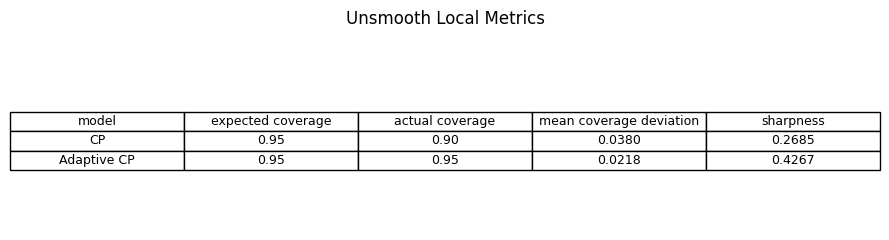

In [14]:
plot_metrics_table(None,None,None,None,cp_df_local,adap_df_local,"CP" ,"Adaptive CP", alpha_level=0.05, 
  main_title="Unsmooth Local Metrics"
)


In [15]:
# Smooth region metrics

# CP Coverage comparison
from utils_extension.utils_uq_adapcp import adaptive_cp_test_uncertainties_grid, cp_test_uncertainties_in_noisy_region
# Conformal-prediction settings
from utils_tools.utils_result_metrics import generating_alphas




cp_testing_args = {
    "uqmodel": dist_feat_pinn_cp,
    "alphas":alphas, 
    "X_test":X_test, "Y_test":Y_test, 
    "X_cal":X_calibration, "Y_cal":Y_calibration, 
    "X_train":X_train, "Y_train":Y_train, 
    "idx_noisy_test":id_test,
    "heuristic_u":raw_heuristic, # Change base on if the baseline cp
    "k":k,
    "compt_smooth":True

}
adapcp_testing_args = {
    "base_md": dist_feat_pinn,
    "alphas":alphas, 
    "X_test":X_test, "Y_test":Y_test, 
    "X_cal":X_calibration, "Y_cal":Y_calibration, 
    "X_train":X_train, "Y_train":Y_train, 
    "idx_noisy_test":id_test,
    "heuristic_u":raw_heuristic, # Change base on if the baseline cp
    "k":k,
    "conf_nn_hidden_layers":(16, 32, 64, 64, 64, 32, 16),
    "conf_nn_lr":3e-5,
    "conf_nn_epochs":20000,
    "training_kwargs":training_kwargs,
    "quant_seed":seed,
    "compt_smooth":True
}
cp_df_local_smooth = cp_test_uncertainties_in_noisy_region(**cp_testing_args)
adap_df_local_smooth = adaptive_cp_test_uncertainties_grid_2d_ac(**adapcp_testing_args)

Adaptive-CP grid:   0%|          | 0/19 [00:00<?, ?it/s]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:   5%|▌         | 1/19 [00:20<06:17, 20.99s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  11%|█         | 2/19 [00:42<06:02, 21.31s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  16%|█▌        | 3/19 [01:04<05:44, 21.52s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  21%|██        | 4/19 [01:25<05:21, 21.45s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  26%|██▋       | 5/19 [01:45<04:53, 20.97s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  32%|███▏      | 6/19 [02:06<04:29, 20.76s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  37%|███▋      | 7/19 [02:27<04:11, 20.95s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  42%|████▏     | 8/19 [02:46<03:44, 20.36s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  47%|████▋     | 9/19 [03:04<03:16, 19.66s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  53%|█████▎    | 10/19 [03:24<02:56, 19.65s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  58%|█████▊    | 11/19 [03:44<02:39, 19.93s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  63%|██████▎   | 12/19 [04:04<02:19, 19.89s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  68%|██████▊   | 13/19 [04:24<01:59, 19.94s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  74%|███████▎  | 14/19 [04:45<01:40, 20.15s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  79%|███████▉  | 15/19 [05:04<01:18, 19.71s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  84%|████████▍ | 16/19 [05:23<00:58, 19.65s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  89%|████████▉ | 17/19 [05:44<00:40, 20.04s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  95%|█████████▍| 18/19 [06:02<00:19, 19.54s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid: 100%|██████████| 19/19 [06:22<00:00, 20.15s/it]


Uncal dev:0.027021038035551708
Cal dev:0.02595622136834122


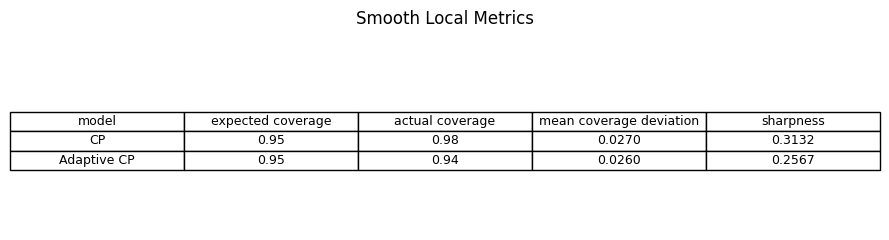

In [16]:
# from utils_tools.utils_result_viz import plot_metrics_table

df1=cp_df_local_smooth
df2=adap_df_local_smooth
df1_name="CP" 
df2_name="Adaptive CP"
# save_plot(
#     plot_metrics_table,
#     save_dir="Adaptive_scaled_CP",
#     prefix="adpcp_vs_cp_table_GLOBAL"
# )(None,None,None,None,df1,df2,df1_name,df2_name, alpha_level=0.05, 
#   main_title="Adaptive Conformal Prediction and Conformal Prediction Metrics")


plot_metrics_table(None,None,None,None,df1,df2,df1_name,df2_name, alpha_level=0.05, 
  main_title="Smooth Local Metrics"
)

In [17]:
# Global Metrics

# CP Coverage comparison
from utils_extension.utils_uq_adapcp import adaptive_cp_test_uncertainties_grid, cp_test_uncertainties_in_noisy_region
from utils_tools.utils_result_metrics import cp_test_uncertainties
# Conformal-prediction settings
from utils_tools.utils_result_metrics import generating_alphas

cp_testing_args = {
    "uqmodel": dist_feat_pinn_cp,
    "alphas":alphas, 
    "X_test":X_test, "Y_test":Y_test, 
    "X_cal":X_calibration, "Y_cal":Y_calibration, 
    "X_train":X_train, "Y_train":Y_train, 
    "heuristic_u":raw_heuristic, # Change base on if the baseline cp
    "k":k
}
adapcp_testing_args = {
    "base_md": dist_feat_pinn,
    "alphas":alphas, 
    "X_test":X_test, "Y_test":Y_test, 
    "X_cal":X_calibration, "Y_cal":Y_calibration, 
    "X_train":X_train, "Y_train":Y_train, 
    "heuristic_u":raw_heuristic, # Change base on if the baseline cp
    "k":k,
    "conf_nn_hidden_layers":(16, 32, 64, 64, 64, 32, 16),
    "conf_nn_lr":3e-5,
    "conf_nn_epochs":20000,
    "training_kwargs":training_kwargs,
    "quant_seed":seed
}
cp_df_global = cp_test_uncertainties(**cp_testing_args)
adap_df_global = adaptive_cp_test_uncertainties_grid_2d_ac(**adapcp_testing_args)

Adaptive-CP grid:   0%|          | 0/19 [00:00<?, ?it/s]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:   5%|▌         | 1/19 [00:20<06:13, 20.73s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  11%|█         | 2/19 [00:40<05:43, 20.22s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  16%|█▌        | 3/19 [01:01<05:27, 20.46s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  21%|██        | 4/19 [01:22<05:08, 20.55s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  26%|██▋       | 5/19 [01:41<04:39, 20.00s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  32%|███▏      | 6/19 [02:01<04:23, 20.29s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  37%|███▋      | 7/19 [02:21<04:00, 20.05s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  42%|████▏     | 8/19 [02:40<03:38, 19.83s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  47%|████▋     | 9/19 [02:59<03:16, 19.62s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  53%|█████▎    | 10/19 [03:19<02:56, 19.62s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  58%|█████▊    | 11/19 [03:38<02:35, 19.49s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  63%|██████▎   | 12/19 [03:59<02:19, 19.93s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  68%|██████▊   | 13/19 [04:20<02:00, 20.16s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  74%|███████▎  | 14/19 [04:39<01:39, 19.80s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  79%|███████▉  | 15/19 [05:00<01:20, 20.18s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  84%|████████▍ | 16/19 [05:20<01:00, 20.21s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  89%|████████▉ | 17/19 [05:40<00:39, 19.95s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  95%|█████████▍| 18/19 [05:58<00:19, 19.49s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid: 100%|██████████| 19/19 [06:19<00:00, 19.95s/it]


Uncal dev:0.01323808960261799
Cal dev:0.01938095467076415


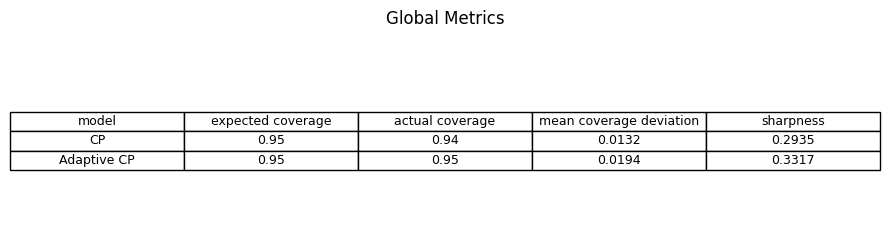

In [18]:
df1=cp_df_global
df2=adap_df_global
df1_name="CP" 
df2_name="Adaptive CP"

plot_metrics_table(None,None,None,None,df1,df2,df1_name,df2_name, alpha_level=0.05, 
  main_title="Global Metrics"
)

# Plot the results

In [19]:
def plot_2D_comparison_with_coverage_error_compare(
    XY_test,
    error,
    pred_set_uncal,
    pred_set_cp,
    pred_set_local_cp,
    true_solution,
    *,
    grid_size=200,
    show_pts=False,
    X_pts=None,
    vlim_error=None,
    vlim_width=None,
    cmap_error="magma",
    cmap_width="viridis",
    title_fontsize=16,
    tick_labelsize=10,
):
    """
    Minimal 4x1 layout:
      [ |ŷ - y| ,  width (Before CP),  width (After CP),  width (After Local CP) ]

    Args:
        XY_test: (N,2) torch.Tensor or np.ndarray used for domain bounds (min/max).
        error:   None or array-like. If None, error = |mean_uncal - true|.
                 If provided, can be length G (=grid_size^2) or len(XY_test),
                 in which case it is NN-projected onto the grid.
        pred_set_*: tuple (lower, upper) for each variant; each can be torch/np arrays
                    of length G (=grid_size^2) matching the grid created here.
        true_solution: callable(XY_grid_tensor) -> (G,1) or (G,) values on our grid.
        grid_size: side length of the visualization grid.
        show_pts: whether to overlay sample points (X_pts).
        X_pts: optional (M,2) points to overlay.
        vlim_error: (vmin, vmax) for error; if None computed from data.
        vlim_width: (vmin, vmax) for widths; if None computed from all three width maps.
        cmap_error, cmap_width: colormap names for error/widths.
    Returns:
        fig, axs: matplotlib Figure and list of 4 Axes [ax_err, ax_wb, ax_wc, ax_wlcp]
    """
    import numpy as np
    import torch
    import matplotlib.pyplot as plt
    import matplotlib.colors as mcolors

    def to_numpy(t):
        if isinstance(t, torch.Tensor):
            return t.detach().cpu().numpy()
        return np.asarray(t)

    def _scatter_to_grid(vals_scatter, XY_scatter, Xg, Yg):
        """Nearest-neighbor map from scatter (N,) onto (grid_size, grid_size)."""
        XYs = to_numpy(XY_scatter).reshape(-1, 2)
        v   = to_numpy(vals_scatter).reshape(-1)
        P   = np.stack([Xg.ravel(), Yg.ravel()], axis=1)  # (G,2)
        d2  = ((P[:, None, :] - XYs[None, :, :]) ** 2).sum(axis=2)
        idx = d2.argmin(axis=1)
        return v[idx].reshape(grid_size, grid_size)

    # ----- Build a regular grid over the XY_test bounds -----
    xy_np = to_numpy(XY_test)
    x_lin = np.linspace(xy_np[:,0].min(), xy_np[:,0].max(), grid_size)
    y_lin = np.linspace(xy_np[:,1].min(), xy_np[:,1].max(), grid_size)
    Xg, Yg = np.meshgrid(x_lin, y_lin)
    XY_grid = torch.tensor(np.stack([Xg.ravel(), Yg.ravel()], axis=1),
                           dtype=XY_test.dtype if isinstance(XY_test, torch.Tensor) else torch.float32)
    extent = [x_lin.min(), x_lin.max(), y_lin.min(), y_lin.max()]
    G = grid_size * grid_size

    # ----- True field on the grid -----
    true_grid = to_numpy(true_solution(XY_grid)).reshape(grid_size, grid_size)

    # ----- Prep intervals -> mean + width (reshape to grid) -----
    def prep_interval(pred_set):
        lower = to_numpy(pred_set[0]).reshape(-1)
        upper = to_numpy(pred_set[1]).reshape(-1)
        mean  = (lower + upper) / 2.0
        width = upper - lower
        return mean.reshape(grid_size, grid_size), width.reshape(grid_size, grid_size)

    mean_uncal,       width_uncal         = prep_interval(pred_set_uncal)
    mean_cp,          width_cp            = prep_interval(pred_set_cp)
    mean_local_cp,    width_local_cp      = prep_interval(pred_set_local_cp)

    # ----- Error grid -----
    if error is None:
        err_grid = np.abs(mean_uncal - true_grid)
    else:
        err_np = to_numpy(error).reshape(-1)
        if err_np.size == G:
            err_grid = err_np.reshape(grid_size, grid_size)
        elif err_np.size == xy_np.shape[0]:
            err_grid = _scatter_to_grid(err_np, xy_np, Xg, Yg)
        else:
            raise ValueError(
                f"`error` must have length {G} or len(XY_test)={xy_np.shape[0]}, got {err_np.size}."
            )

    # ----- vlims -----
    if vlim_error is None:
        e_min, e_max = float(np.nanmin(err_grid)), float(np.nanmax(err_grid))
        if not np.isfinite(e_min) or not np.isfinite(e_max) or e_min == e_max:
            e_min, e_max = 0.0, 1.0
        vlim_error = (e_min, e_max)

    if vlim_width is None:
        w_min = float(np.nanmin([width_uncal.min(), width_cp.min(), width_local_cp.min()]))
        w_max = float(np.nanmax([width_uncal.max(), width_cp.max(), width_local_cp.max()]))
        if not np.isfinite(w_min) or not np.isfinite(w_max) or w_min == w_max:
            w_min, w_max = 0.0, 1.0
        vlim_width = (w_min, w_max)

    # ----- Figure & axes (4 by 1) -----
    fig, axs = plt.subplots(1, 4, figsize=(22, 5), constrained_layout=True)
    ax_err, ax_wb, ax_wc, ax_wlcp = axs

    # ----- Draw images -----
    im_err = ax_err.imshow(err_grid, extent=extent, origin='lower', aspect='auto',
                           interpolation='bilinear', cmap=cmap_error,
                           vmin=vlim_error[0], vmax=vlim_error[1])
    ax_err.set_title("Error  |ŷ − y|", fontsize=title_fontsize)
    ax_err.set_xlabel("x", fontsize=tick_labelsize)
    ax_err.set_ylabel("y", fontsize=tick_labelsize)

    im_wb  = ax_wb.imshow(width_uncal, extent=extent, origin='lower', aspect='auto',
                          interpolation='bilinear', cmap=cmap_width,
                          vmin=vlim_width[0], vmax=vlim_width[1])
    ax_wb.set_title("Width — Before CP", fontsize=title_fontsize)
    ax_wb.set_xlabel("x", fontsize=tick_labelsize)
    ax_wb.set_yticks([])

    im_wc  = ax_wc.imshow(width_cp, extent=extent, origin='lower', aspect='auto',
                          interpolation='bilinear', cmap=cmap_width,
                          vmin=vlim_width[0], vmax=vlim_width[1])
    ax_wc.set_title("Width — After CP", fontsize=title_fontsize)
    ax_wc.set_xlabel("x", fontsize=tick_labelsize)
    ax_wc.set_yticks([])

    im_wl  = ax_wlcp.imshow(width_local_cp, extent=extent, origin='lower', aspect='auto',
                            interpolation='bilinear', cmap=cmap_width,
                            vmin=vlim_width[0], vmax=vlim_width[1])
    ax_wlcp.set_title("Width — After Local CP", fontsize=title_fontsize)
    ax_wlcp.set_xlabel("x", fontsize=tick_labelsize)
    ax_wlcp.set_yticks([])

    # ----- Optional scatter points -----
    if show_pts and X_pts is not None:
        pts = to_numpy(X_pts)
        for ax in axs:
            ax.scatter(pts[:,0], pts[:,1], s=10, c="k", alpha=0.8)

    # ----- Colorbars: one for error (ax_err), one shared for widths (ax_wb, ax_wc, ax_wlcp) -----
    cbar_err = fig.colorbar(im_err, ax=ax_err, orientation='horizontal', fraction=0.06, pad=0.12)
    cbar_err.ax.tick_params(labelsize=tick_labelsize)
    cbar_w   = fig.colorbar(im_wb, ax=[ax_wb, ax_wc, ax_wlcp], orientation='horizontal', fraction=0.06, pad=0.12)
    cbar_w.ax.tick_params(labelsize=tick_labelsize)

    return fig, axs


In [20]:
def plot_2D_comparison_with_coverage_error_compare(
    XY_test,
    error,
    pred_set_uncal,
    pred_set_cp,
    pred_set_local_cp,
    true_solution,
    *,
    grid_size=200,
    show_pts=False,
    X_pts=None,
    vlim_error=None,
    vlim_width=None,
    cmap_error="magma",
    cmap_width="viridis",
    title_fontsize=16,
    tick_labelsize=10,
):
    """
    Minimal 4x1 layout:
      [ |ŷ - y| ,  width (Before CP),  width (After CP),  width (After Local CP) ]

    Args:
        XY_test: (N,2) torch.Tensor or np.ndarray used for domain bounds (min/max).
        error:   None or array-like. If None, error = |mean_uncal - true|.
                 If provided, can be length G (=grid_size^2) or len(XY_test),
                 in which case it is NN-projected onto the grid.
        pred_set_*: tuple (lower, upper) for each variant; each can be torch/np arrays
                    of length G (=grid_size^2) matching the grid created here.
        true_solution: callable(XY_grid_tensor) -> (G,1) or (G,) values on our grid.
        grid_size: side length of the visualization grid.
        show_pts: whether to overlay sample points (X_pts).
        X_pts: optional (M,2) points to overlay.
        vlim_error: (vmin, vmax) for error; if None computed from data.
        vlim_width: (vmin, vmax) for widths; if None computed from all three width maps.
        cmap_error, cmap_width: colormap names for error/widths.
    Returns:
        fig, axs: matplotlib Figure and list of 4 Axes [ax_err, ax_wb, ax_wc, ax_wlcp]
    """
    import numpy as np
    import torch
    import matplotlib.pyplot as plt
    import matplotlib.colors as mcolors

    def to_numpy(t):
        if isinstance(t, torch.Tensor):
            return t.detach().cpu().numpy()
        return np.asarray(t)

    def _scatter_to_grid(vals_scatter, XY_scatter, Xg, Yg):
        """Nearest-neighbor map from scatter (N,) onto (grid_size, grid_size)."""
        XYs = to_numpy(XY_scatter).reshape(-1, 2)
        v   = to_numpy(vals_scatter).reshape(-1)
        P   = np.stack([Xg.ravel(), Yg.ravel()], axis=1)  # (G,2)
        d2  = ((P[:, None, :] - XYs[None, :, :]) ** 2).sum(axis=2)
        idx = d2.argmin(axis=1)
        return v[idx].reshape(grid_size, grid_size)

    # ----- Build a regular grid over the XY_test bounds -----
    xy_np = to_numpy(XY_test)
    x_lin = np.linspace(xy_np[:,0].min(), xy_np[:,0].max(), grid_size)
    y_lin = np.linspace(xy_np[:,1].min(), xy_np[:,1].max(), grid_size)
    Xg, Yg = np.meshgrid(x_lin, y_lin)
    XY_grid = torch.tensor(np.stack([Xg.ravel(), Yg.ravel()], axis=1),
                           dtype=XY_test.dtype if isinstance(XY_test, torch.Tensor) else torch.float32)
    extent = [x_lin.min(), x_lin.max(), y_lin.min(), y_lin.max()]
    G = grid_size * grid_size

    # ----- True field on the grid -----
    true_grid = to_numpy(true_solution(XY_grid)).reshape(grid_size, grid_size)

    # ----- Prep intervals -> mean + width (reshape to grid) -----
    def prep_interval(pred_set):
        lower = to_numpy(pred_set[0]).reshape(-1)
        upper = to_numpy(pred_set[1]).reshape(-1)
        mean  = (lower + upper) / 2.0
        width = upper - lower
        return mean.reshape(grid_size, grid_size), width.reshape(grid_size, grid_size)

    mean_uncal,       width_uncal         = prep_interval(pred_set_uncal)
    mean_cp,          width_cp            = prep_interval(pred_set_cp)
    mean_local_cp,    width_local_cp      = prep_interval(pred_set_local_cp)

    # ----- Error grid -----
    if error is None:
        err_grid = np.abs(mean_uncal - true_grid)
    else:
        err_np = to_numpy(error).reshape(-1)
        if err_np.size == G:
            err_grid = err_np.reshape(grid_size, grid_size)
        elif err_np.size == xy_np.shape[0]:
            err_grid = _scatter_to_grid(err_np, xy_np, Xg, Yg)
        else:
            raise ValueError(
                f"`error` must have length {G} or len(XY_test)={xy_np.shape[0]}, got {err_np.size}."
            )

    # ----- vlims -----
    if vlim_error is None:
        e_min, e_max = float(np.nanmin(err_grid)), float(np.nanmax(err_grid))
        if not np.isfinite(e_min) or not np.isfinite(e_max) or e_min == e_max:
            e_min, e_max = 0.0, 1.0
        vlim_error = (e_min, e_max)

    if vlim_width is None:
        w_min = float(np.nanmin([width_uncal.min(), width_cp.min(), width_local_cp.min()]))
        w_max = float(np.nanmax([width_uncal.max(), width_cp.max(), width_local_cp.max()]))
        if not np.isfinite(w_min) or not np.isfinite(w_max) or w_min == w_max:
            w_min, w_max = 0.0, 1.0
        vlim_width = (w_min, w_max)

    # ----- Figure & axes (4 by 1) -----
    fig, axs = plt.subplots(1, 4, figsize=(22, 5), constrained_layout=True)
    ax_err, ax_wb, ax_wc, ax_wlcp = axs

    # ----- Draw images -----
    im_err = ax_err.imshow(err_grid, extent=extent, origin='lower', aspect='auto',
                           interpolation='bilinear', cmap=cmap_error,
                           vmin=vlim_error[0], vmax=vlim_error[1])
    ax_err.set_title("Error  |ŷ − y|", fontsize=title_fontsize)
    ax_err.set_xlabel("x", fontsize=tick_labelsize)
    ax_err.set_ylabel("y", fontsize=tick_labelsize)

    im_wb  = ax_wb.imshow(width_uncal, extent=extent, origin='lower', aspect='auto',
                          interpolation='bilinear', cmap=cmap_width,
                          vmin=vlim_width[0], vmax=vlim_width[1])
    ax_wb.set_title("Width — Before CP", fontsize=title_fontsize)
    ax_wb.set_xlabel("x", fontsize=tick_labelsize)
    ax_wb.set_yticks([])

    im_wc  = ax_wc.imshow(width_cp, extent=extent, origin='lower', aspect='auto',
                          interpolation='bilinear', cmap=cmap_width,
                          vmin=vlim_width[0], vmax=vlim_width[1])
    ax_wc.set_title("Width — After CP", fontsize=title_fontsize)
    ax_wc.set_xlabel("x", fontsize=tick_labelsize)
    ax_wc.set_yticks([])

    im_wl  = ax_wlcp.imshow(width_local_cp, extent=extent, origin='lower', aspect='auto',
                            interpolation='bilinear', cmap=cmap_width,
                            vmin=vlim_width[0], vmax=vlim_width[1])
    ax_wlcp.set_title("Width — After Local CP", fontsize=title_fontsize)
    ax_wlcp.set_xlabel("x", fontsize=tick_labelsize)
    ax_wlcp.set_yticks([])

    # ----- Optional scatter points -----
    if show_pts and X_pts is not None:
        pts = to_numpy(X_pts)
        for ax in axs:
            ax.scatter(pts[:,0], pts[:,1], s=10, c="k", alpha=0.8)

    # ----- Colorbars: one for error (ax_err), one shared for widths (ax_wb, ax_wc, ax_wlcp) -----
    cbar_err = fig.colorbar(im_err, ax=ax_err, orientation='horizontal', fraction=0.06, pad=0.12)
    cbar_err.ax.tick_params(labelsize=tick_labelsize)
    cbar_w   = fig.colorbar(im_wb, ax=[ax_wb, ax_wc, ax_wlcp], orientation='horizontal', fraction=0.06, pad=0.12)
    cbar_w.ax.tick_params(labelsize=tick_labelsize)

    return fig, axs


In [22]:

@torch.no_grad()
def estimate_true_error_local_max(
    xy: torch.Tensor,          # (N, 2)
    u: torch.Tensor,           # (N, 1)  <-- use your observed y if you want data noise; don't pass model mean
    nghd_size,                 # float -> radius mode; int>=1 -> kNN mode
    *,
    include_self: bool = True,
    chunk_size: int = 4096,
) -> torch.Tensor:
    """
    For each point i, compute a local noise proxy:
        noise(i) = max_{j,k in N(i)} |u[j] - u[k]|
                  = (max_{j in N(i)} u[j]) - (min_{k in N(i)} u[k])

    Neighborhood N(i):
        - Radius mode (nghd_size: float): points with dist <= radius.
        - kNN mode    (nghd_size: int>=1): k nearest neighbors.

    Returns:
        (N,1) tensor of local ranges per point.

    Notes:
      • If you want "intrinsic data noise", pass your *observed* targets with noise as `u`.
      • Using ground-truth noiseless u will measure local function variability instead.
    """
    assert xy.ndim == 2 and xy.shape[1] == 2, "xy must be (N, 2)"
    assert u.ndim == 2 and u.shape[1] == 1, "u must be (N, 1)"
    N = xy.shape[0]
    device = xy.device
    u1 = u.squeeze(1)  # (N,)

    # ---------- kNN mode ----------
    if isinstance(nghd_size, int):
        assert nghd_size >= 1, "For kNN mode, nghd_size must be int>=1"
        k = min(nghd_size, N)
        row_block = max(1, chunk_size // 4)

        out = torch.empty((N,), device=device)
        for r0 in range(0, N, row_block):
            r1 = min(N, r0 + row_block)
            dists = torch.cdist(xy[r0:r1], xy)  # (r, N)

            if not include_self:
                for i in range(r0, r1):
                    dists[i - r0, i] = inf

            _, idx = torch.topk(dists, k=k, largest=False, dim=1)   # (r, k)
            neigh_u = u1[idx]                                       # (r, k)
            local_max = neigh_u.max(dim=1).values
            local_min = neigh_u.min(dim=1).values
            out[r0:r1] = (local_max - local_min)

        return out.unsqueeze(1)

    # ---------- radius mode ----------
    elif isinstance(nghd_size, float):
        radius = nghd_size
        assert radius > 0.0, "For radius mode, nghd_size must be a positive float"

        # Running extrema per row
        run_max = torch.full((N,), -inf, device=device)
        run_min = torch.full((N,),  inf, device=device)

        for c0 in range(0, N, chunk_size):
            c1 = min(N, c0 + chunk_size)
            dblock = torch.cdist(xy, xy[c0:c1])                     # (N, B)

            if not include_self:
                idx_rows = torch.arange(c0, c1, device=device)
                dblock[idx_rows, idx_rows - c0] = inf               # remove self

            mask = dblock <= radius                                 # (N, B)
            u_block = u1[c0:c1].unsqueeze(0).expand_as(dblock)      # (N, B)

            # masked maxima/minima in this block
            blk_max = torch.where(mask, u_block, torch.full_like(u_block, -inf)).max(dim=1).values
            blk_min = torch.where(mask, u_block, torch.full_like(u_block,  inf)).min(dim=1).values

            # update running extrema
            run_max = torch.maximum(run_max, blk_max)
            run_min = torch.minimum(run_min, blk_min)

        # Rows with no neighbors found (possible only if include_self=False and radius tiny)
        no_neigh = torch.isinf(run_max) | torch.isinf(run_min)
        if no_neigh.any():
            # define their range as 0 (or use self value to avoid NaNs)
            run_max[no_neigh] = u1[no_neigh]
            run_min[no_neigh] = u1[no_neigh]

        return (run_max - run_min).unsqueeze(1)

    else:
        raise ValueError("nghd_size must be int (kNN) or float (radius).")
    

In [23]:
err_est_noise = estimate_true_error_local_max(grid_test, u_noisy, nghd_size=7)

In [24]:
grid_test.shape

torch.Size([40000, 2])

In [25]:
# CP Model (Adaptive)
from utils_extension.utils_uq_adapcp import AdaptiveCP_f, adaptive_cp_test_uncertainties_grid
training_kwargs={"step_size":4000, "gamma":0.5}
adap_kwarg={
    "alpha":alpha,
    "heuristic":raw_heuristic,
    "conf_nn_hidden_layers":(16, 32, 64, 64, 64, 32, 16),
    "conf_nn_lr":3e-5,
    "conf_nn_epochs":20000,
    "training_kwargs":training_kwargs,
    "quant_seed":seed
}

adap_cp = AdaptiveCP_f(dist_feat_pinn, **adap_kwarg)
adp_cp_cal_predset = adap_cp.predict(
    alpha=alpha, X_test=grid_test, X_train=X_train, Y_train=Y_train,
    X_cal=X_calibration, Y_cal=Y_calibration, k=k
)


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


/var/folders/nk/7m8bs7zj68dcqhl1g64gcwh80000gn/T/ipykernel_73018/2853600904.py:172: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


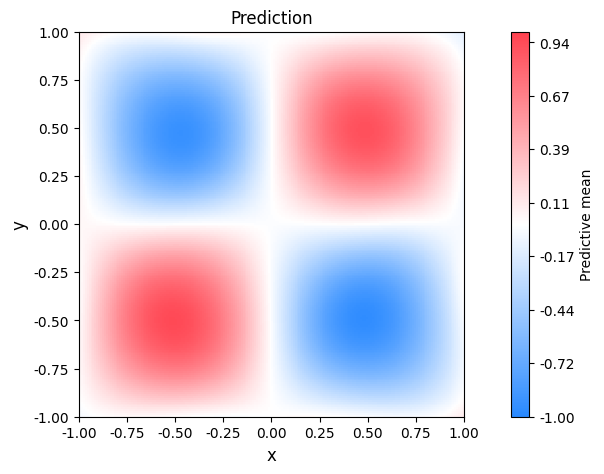

In [26]:
cbar_kwargs = {"ticks": np.linspace(-1.0, 1.5, 10), "format": "%.2f"}
vlim_mean = (-1.0, 1.0)
fig, ax, field = plot_uq_field(grid_test, pde.true_solution, dist_feat_pinn_cp_cal_predset, mode="mean",
                               vlim=vlim_mean, cbar_kwargs=cbar_kwargs, title="Prediction")


In [34]:
# CP Model (Adaptive)
from utils_extension.utils_uq_adapcp import AdaptiveCP_f, adaptive_cp_test_uncertainties_grid
training_kwargs={"step_size":5000, "gamma":0.5}
adap_kwarg={
    "alpha":alpha,
    "heuristic":raw_heuristic,
    "conf_nn_hidden_layers":(16, 32, 64, 64, 64, 32, 16),
    "conf_nn_lr":1e-4,
    "conf_nn_epochs":20000,
    "training_kwargs":training_kwargs,
    "quant_seed":seed
}

adap_cp = AdaptiveCP_f(dist_feat_pinn, **adap_kwarg)
adp_cp_cal_predset = adap_cp.predict(
    alpha=alpha, X_test=grid_test, X_train=X_train, Y_train=Y_train,
    X_cal=X_calibration, Y_cal=Y_calibration, k=k
)


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


In [35]:
def plot_2D_comparison_with_coverage_error_compare(
    XY_test,
    error,
    pred_set_uncal,
    pred_set_cp,
    pred_set_local_cp,
    true_solution,
    *,
    grid_size=200,
    show_pts=False,
    X_pts=None,
    vlim=None,                # one shared vlim for ALL panels; auto if None
    cmap=my_cmap,           # one unique cmap for ALL panels
    title_fontsize=16,
    tick_labelsize=10,
    wspace=0.15,              # spacing between the 4 panels
):
    """
    4×1 panels (left→right): |ŷ - y|, width Before CP, width After CP, width After Local CP
    - Single shared colormap + single colorbar placed to the right of the entire row.
    - `vlim`: (vmin, vmax) shared across all panels; auto-computed from all fields if None.
    - `wspace`: horizontal spacing between panels.
    """
    import numpy as np
    import torch
    import matplotlib.pyplot as plt
    import matplotlib.colors as mcolors

    def to_numpy(t):
        if isinstance(t, torch.Tensor):
            return t.detach().cpu().numpy()
        return np.asarray(t)

    def _scatter_to_grid(vals_scatter, XY_scatter, Xg, Yg):
        """Nearest-neighbor map from scatter (N,) onto (grid_size, grid_size)."""
        XYs = to_numpy(XY_scatter).reshape(-1, 2)
        v   = to_numpy(vals_scatter).reshape(-1)
        P   = np.stack([Xg.ravel(), Yg.ravel()], axis=1)  # (G,2)
        d2  = ((P[:, None, :] - XYs[None, :, :]) ** 2).sum(axis=2)
        idx = d2.argmin(axis=1)
        return v[idx].reshape(grid_size, grid_size)

    # ---- Build grid over XY_test bounds ----
    xy_np = to_numpy(XY_test)
    x_lin = np.linspace(xy_np[:,0].min(), xy_np[:,0].max(), grid_size)
    y_lin = np.linspace(xy_np[:,1].min(), xy_np[:,1].max(), grid_size)
    Xg, Yg = np.meshgrid(x_lin, y_lin)
    XY_grid = torch.tensor(
        np.stack([Xg.ravel(), Yg.ravel()], axis=1),
        dtype=(XY_test.dtype if isinstance(XY_test, torch.Tensor) else torch.float32),
    )
    extent = [x_lin.min(), x_lin.max(), y_lin.min(), y_lin.max()]
    G = grid_size * grid_size

    # ---- True field on the grid ----
    true_grid = to_numpy(true_solution(XY_grid)).reshape(grid_size, grid_size)

    # ---- Intervals -> mean + width (reshaped to grid) ----
    def prep_interval(pred_set):
        lower = to_numpy(pred_set[0]).reshape(-1)
        upper = to_numpy(pred_set[1]).reshape(-1)
        mean  = (lower + upper) / 2.0
        width = upper - lower
        return mean.reshape(grid_size, grid_size), width.reshape(grid_size, grid_size)

    mean_uncal,    width_uncal    = prep_interval(pred_set_uncal)
    mean_cp,       width_cp       = prep_interval(pred_set_cp)
    mean_lcp,      width_lcp      = prep_interval(pred_set_local_cp)

    # ---- Error grid ----
    if error is None:
        err_grid = np.abs(mean_uncal - true_grid)
    else:
        err_np = to_numpy(error).reshape(-1)
        if err_np.size == G:
            err_grid = err_np.reshape(grid_size, grid_size)
        elif err_np.size == xy_np.shape[0]:
            err_grid = _scatter_to_grid(err_np, xy_np, Xg, Yg)
        else:
            raise ValueError(
                f"`error` must have length {G} or len(XY_test)={xy_np.shape[0]}, got {err_np.size}."
            )

    # ---- Shared vlim across ALL panels ----
    if vlim is None:
        vmin = float(
            np.nanmin([err_grid.min(), width_uncal.min(), width_cp.min(), width_lcp.min()])
        )
        vmax = float(
            np.nanmax([err_grid.max(), width_uncal.max(), width_cp.max(), width_lcp.max()])
        )
        if not np.isfinite(vmin) or not np.isfinite(vmax) or vmin == vmax:
            vmin, vmax = 0.0, 1.0
        vlim = (vmin, vmax)

    norm = mcolors.Normalize(vmin=vlim[0], vmax=vlim[1])

    # ---- Figure & axes (4 by 1) ----
    fig, axs = plt.subplots(1, 4, figsize=(22, 5), gridspec_kw={"wspace": wspace})
    ax_err, ax_wb, ax_wc, ax_wlcp = axs

    # ---- Draw images with one shared cmap/norm ----
    im_err = ax_err.imshow(err_grid, extent=extent, origin='lower', aspect='auto',
                           interpolation='bilinear', cmap=cmap, norm=norm)
    ax_err.set_title("|ŷ − y|", fontsize=title_fontsize)
    ax_err.set_xlabel("x", fontsize=tick_labelsize)
    ax_err.set_ylabel("y", fontsize=tick_labelsize)

    im_wb  = ax_wb.imshow(width_uncal, extent=extent, origin='lower', aspect='auto',
                          interpolation='bilinear', cmap=cmap, norm=norm)
    ax_wb.set_title("Width — Before CP", fontsize=title_fontsize)
    ax_wb.set_xlabel("x", fontsize=tick_labelsize)
    ax_wb.set_yticks([])

    im_wc  = ax_wc.imshow(width_cp, extent=extent, origin='lower', aspect='auto',
                          interpolation='bilinear', cmap=cmap, norm=norm)
    ax_wc.set_title("Width — After CP", fontsize=title_fontsize)
    ax_wc.set_xlabel("x", fontsize=tick_labelsize)
    ax_wc.set_yticks([])

    im_wl  = ax_wlcp.imshow(width_lcp, extent=extent, origin='lower', aspect='auto',
                            interpolation='bilinear', cmap=cmap, norm=norm)
    ax_wlcp.set_title("Width — After Local CP", fontsize=title_fontsize)
    ax_wlcp.set_xlabel("x", fontsize=tick_labelsize)
    ax_wlcp.set_yticks([])

    # ---- Optional scatter points ----
    if show_pts and X_pts is not None:
        pts = to_numpy(X_pts)
        for ax in axs:
            ax.scatter(pts[:,0], pts[:,1], s=10, c="k", alpha=0.8)

    # ---- Single colorbar on the far right (shared across all axes) ----
    # Use a ScalarMappable so the cbar isn't tied to a specific Axes object.
    sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])  # required for older Matplotlib versions
    cbar = fig.colorbar(sm, ax=axs, location="right", fraction=0.04, pad=0.02)
    cbar.ax.tick_params(labelsize=tick_labelsize)

    return fig, axs


(<Figure size 2200x500 with 5 Axes>,
 array([<Axes: title={'center': '|ŷ − y|'}, xlabel='x', ylabel='y'>,
        <Axes: title={'center': 'Width — Before CP'}, xlabel='x'>,
        <Axes: title={'center': 'Width — After CP'}, xlabel='x'>,
        <Axes: title={'center': 'Width — After Local CP'}, xlabel='x'>],
       dtype=object))

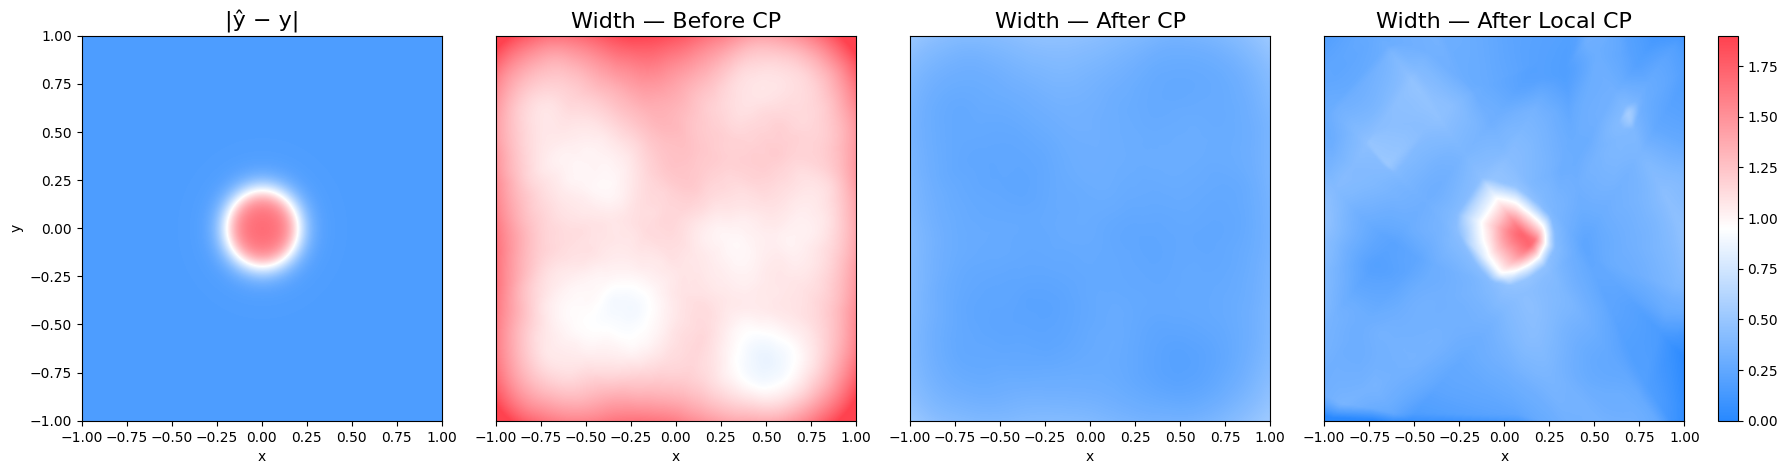

In [36]:
plot_2D_comparison_with_coverage_error_compare(
    grid_test,
    2*(sigma*1.69),
    dist_feat_pinn_uncal_predset,
    dist_feat_pinn_cp_cal_predset,
    adp_cp_cal_predset, #<--
    true_solution, 
    vlim=(0,1.9)
)

# df1=cp_df_local_smooth
# df2=adap_df_local_smooth
# cp_df_local, #<--
# adap_df_local, #<--